In [64]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [ ]:
from vendi_score import vendi
def compute_Vendi(D):
    K_neg_euclidean = -1 * D  
    return vendi.score_K(K_neg_euclidean)

import torch
def compute_DCScore(D):
    K_neg_euclidean = -1 * D
    sim_product = torch.from_numpy(K_neg_euclidean)
    sim_probs = sim_product.softmax(dim=-1)
    diversity = torch.sum(torch.diag(sim_probs))
    return diversity.item()

In [66]:
from PLDiv import compute_PLDiv

In [67]:
from magnipy.diversipy import Diversipy
def compute_MagArea(X):
    div = Diversipy(Xs=X, ref_space=0)
    return div.MagAreas()[0]

In [68]:
def ring(n=200, radius=0.8, noise=0.02, center=(1,1)):
    theta = np.linspace(0, 2*np.pi, n, endpoint=False)
    r = radius + noise*np.random.randn(n)
    x = center[0] + r*np.cos(theta)
    y = center[1] + r*np.sin(theta)
    return np.vstack((x,y)).T
def disk(n=200, radius=0.8, noise=0.02, center=(1,1)):
    r = np.sqrt(np.random.rand(n))*radius + noise*np.random.randn(n)*0.02
    theta = np.random.rand(n)*2*np.pi
    x = center[0] + r*np.cos(theta)
    y = center[1] + r*np.sin(theta)
    return np.vstack((x,y)).T
def two_clusters(n_per=100, sep=0.6, sigma=0.03, center=(1,1)):
    c1 = np.array([center[0]-sep/2, center[1]])
    c2 = np.array([center[0]+sep/2, center[1]])
    a = np.random.multivariate_normal(c1, np.eye(2)*sigma, n_per)
    b = np.random.multivariate_normal(c2, np.eye(2)*sigma, n_per)
    return np.vstack((a,b))
def two_clusters_bridge(n_per=100, sep=0.6, sigma=0.03, bridge_points=10, center=(1,1)):
    base = two_clusters(n_per, sep, sigma, center)
    c1 = base[:n_per].mean(axis=0)
    c2 = base[n_per:].mean(axis=0)
    t = np.linspace(0,1,bridge_points+2)[1:-1]
    bridge = np.vstack([c1*(1-tt)+c2*tt for tt in t]) + np.random.randn(bridge_points,2)*0.01
    return np.vstack((base, bridge))
def nested_clusters(center=(1,1)):
    inner = np.random.multivariate_normal(center, np.eye(2)*0.01, 80)
    outer = ring(120, radius=0.7, noise=0.02, center=center)
    return np.vstack((inner, outer))
def gaussian(n=200, mean=(1,1), cov=None):
    if cov is None: cov = np.eye(2)*0.05
    return np.random.multivariate_normal(mean, cov, n)
def crescent(n=200, noise=0.02, center=(1,1)):
    theta = np.linspace(0, np.pi, n)
    r = 0.8 + noise*np.random.randn(n)
    x = center[0] + r*np.cos(theta)
    y = center[1] + 0.5 + r*np.sin(theta)
    return np.vstack((x,y)).T
def line_snake(n=200, amp=0.2, freq=3, noise=0.02):
    x=np.linspace(0,2,n)
    y=np.sin(freq*x)*amp+1
    pts=np.stack([x,y],axis=1)+noise*np.random.randn(n,2)
    return np.clip(pts,0,2)
def hole_vs_fill(center=(1,1)):
    outer=np.random.multivariate_normal(center,np.eye(2)*0.03,180)
    r_inner=0.2
    theta=np.random.rand(20)*2*np.pi
    hole=np.vstack([center[0]+r_inner*np.cos(theta),center[1]+r_inner*np.sin(theta)]).T
    A=np.vstack((outer[:160],hole))
    B=np.vstack((outer[:160], np.random.multivariate_normal(center,np.eye(2)*0.03,20)))
    return A,B
def hierarchical(center=(1,1)):
    pts=[]
    for big in [(0.7,0),(-0.4,0.3),(0.2,-0.5)]:
        base=[center[0]+big[0],center[1]+big[1]]
        for _ in range(3):
            c=[base[0]+np.random.randn()*0.05,base[1]+np.random.randn()*0.05]
            pts.append(np.random.multivariate_normal(c,np.eye(2)*0.005,10))
    return np.vstack(pts)

In [69]:

np.random.seed(42)
pairs=[]
pairs.append(("Ring vs Disk", ring(), disk()))
pairs.append(("Two clusters vs Bridge", two_clusters(), two_clusters_bridge()))
A3=nested_clusters(); pairs.append(("Nested vs Gaussian", A3, gaussian(cov=np.cov(A3.T))))
pairs.append(("Crescent vs Blob", crescent(), gaussian(cov=np.eye(2)*0.05)))
A6=np.vstack((ring(100,radius=0.4), ring(100,radius=0.9)))
pairs.append(("Two rings vs Random cloud", A6, np.random.rand(200,2)*2))
pairs.append(("Snake vs Blob", line_snake(), gaussian(cov=np.eye(2)*0.05)))
A9,B9=hole_vs_fill(); pairs.append(("Hole vs Filled",A9,B9))
pairs.append(("Hierarchical vs Gaussian", hierarchical(), gaussian(cov=np.eye(2)*0.1)))


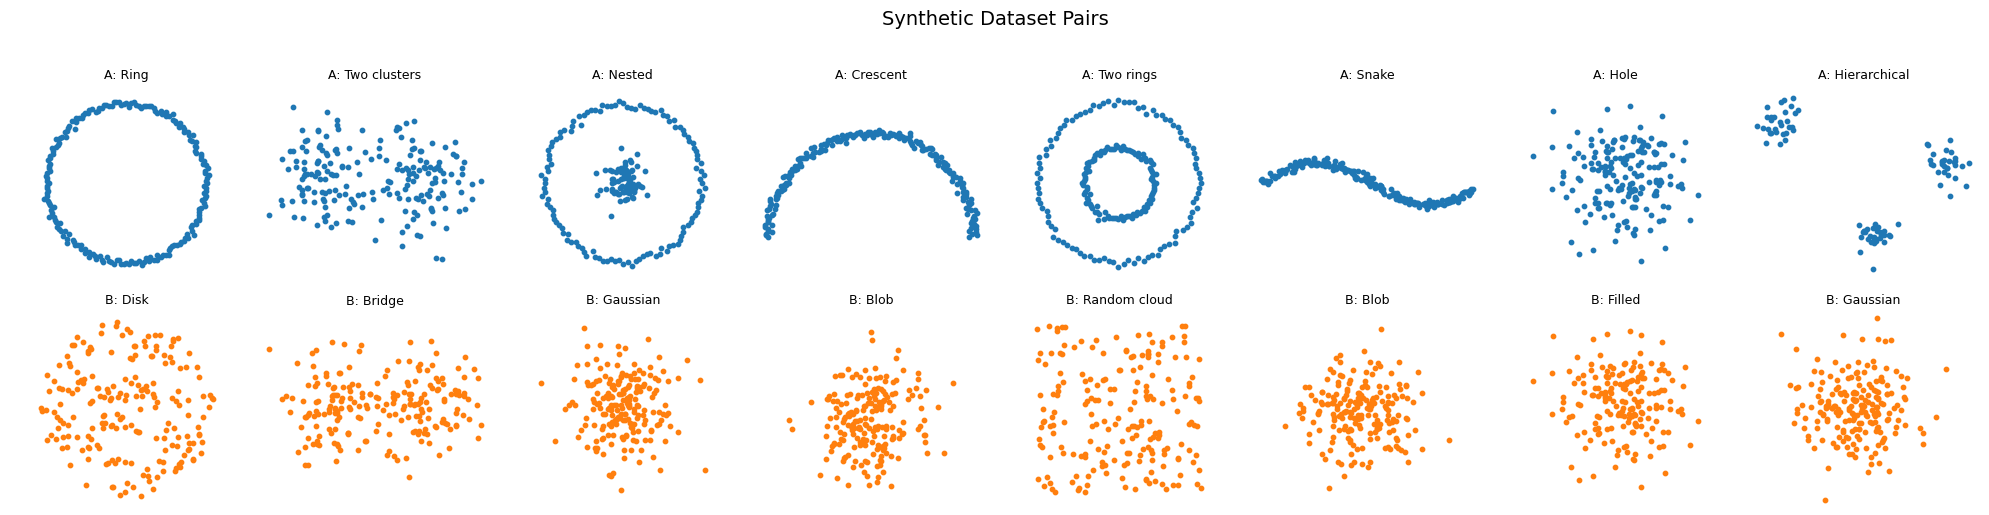

In [70]:
import matplotlib.pyplot as plt
import numpy as np

n_pairs = len(pairs)

fig, axes = plt.subplots(2, n_pairs, figsize=(2.5 * n_pairs, 5)) 

for i, (title, A, B) in enumerate(pairs):
    axA = axes[0, i]
    axA.scatter(A[:, 0], A[:, 1], s=10, color='tab:blue')
    axA.set_title(f"A: {title.split(' vs ')[0]}", fontsize=9)
    axA.axis('equal')
    axA.axis('off')

    axB = axes[1, i]
    axB.scatter(B[:, 0], B[:, 1], s=10, color='tab:orange')
    axB.set_title(f"B: {title.split(' vs ')[1]}", fontsize=9)
    axB.axis('equal')
    axB.axis('off')

plt.suptitle("Synthetic Dataset Pairs", fontsize=14, y=1.02)

plt.tight_layout()
plt.savefig("figs/syn_pairs_horizontal.png", dpi=300, bbox_inches="tight")
plt.show()


In [60]:
rows=[]
for label,A,B in pairs:
    for side,X in zip(["A","B"],[A,B]):
        D=squareform(pdist(X,"euclidean"))
        pldiv = compute_PLDiv(D, distance_matrix=True, hom_deg=0, sparse=None, closed_form=False)
        vendi_score = compute_Vendi(D)
        dc_score = compute_DCScore(D)
        mag_area = compute_MagArea([X])
        rows.append({"pair":label,"side":side,
                     "PLDiv":pldiv,"Vendi Score":vendi_score,"DCScore":dc_score,"MagArea":mag_area})
        
df=pd.DataFrame(rows)

In [61]:
df

,pair,side,PLDiv,Vendi Score,DCScore,MagArea
0,Ring vs Disk,A,0.063774,8.702385,2.437194,125.732389
1,Ring vs Disk,B,0.262076,8.745723,1.957249,140.619835
2,Two clusters vs Bridge,A,0.133595,4.915046,1.577550,143.599462
3,Two clusters vs Bridge,B,0.149917,5.131891,1.584809,153.363736
4,Nested vs Gaussian,A,0.123001,7.695645,1.906380,141.749620
5,Nested vs Gaussian,B,0.623221,9.641004,1.878011,142.508876
6,Crescent vs Blob,A,0.030285,5.025304,1.918801,127.702430
7,Crescent vs Blob,B,0.147462,4.468818,1.449513,136.976374
8,Two rings vs Random cloud,A,0.175969,11.569043,2.257462,132.447277
9,Two rings vs Random cloud,B,0.551491,15.436289,2.583043,140.364339


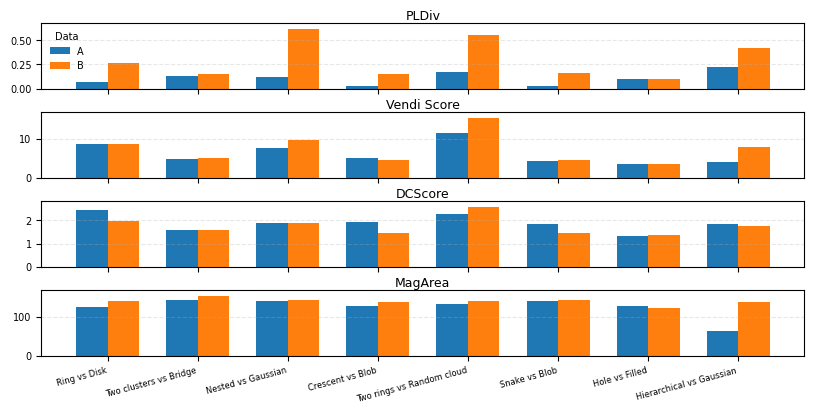

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

metrics = ["PLDiv", "Vendi Score", "DCScore", "MagArea"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 4), sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    pair_order = df["pair"].unique()
    pivot_df = (
        df.pivot(index="pair", columns="side", values=metric)
          .reindex(pair_order, axis=0)
    )
    
    x = range(len(pivot_df))
    width = 0.35

    ax.bar([p - width/2 for p in x], pivot_df["A"], width=width, color="#1f77b4", label="A")
    ax.bar([p + width/2 for p in x], pivot_df["B"], width=width, color="#ff7f0e", label="B")

    ax.set_title(metric, fontsize=9, pad=2)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_df.index, rotation=15, ha="right", fontsize=6)
    ax.tick_params(axis="y", labelsize=7)
    ax.margins(y=0.1)

axes[0].legend(title="Data", loc="upper left", fontsize=7, title_fontsize=7, frameon=False)

plt.tight_layout(pad=0.2, h_pad=0.3, w_pad=0.2)
plt.savefig("figs/AB_comp_small.png", dpi=300, bbox_inches="tight")
plt.show()